# The AR6 Shared Socioeconomic Pathway Effective Radiative Forcing Timeseries, 1750-2500

In [1]:
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as st
import random
import pandas as pd
from tqdm.notebook import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from ar6.constants import NINETY_TO_ONESIGMA

from ar6.twolayermodel import TwoLayerModel

import matplotlib.pyplot as pl
import json

In [2]:
forcing = {}

check_and_download(
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv'
)

check_and_download(
    '../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv'
)
    
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-gidden','ssp370-lowNTCF-aerchemmip','ssp434','ssp460','ssp534-over','ssp585']
for scenario in scenarios:
    forcing[scenario] = {}

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total['NMVOC']
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update
#new_ceds

emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
new_emissions = {}
for scenario in tqdm(scenarios):
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nh3 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NH3'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nmvoc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    bc[:265] = emissions_ceds_update.loc[1750:2014,'BC'].values
    oc[:265] = emissions_ceds_update.loc[1750:2014,'OC'].values
    so2[:265] = emissions_ceds_update.loc[1750:2014,'SO2'].values
    nh3[:265] = emissions_ceds_update.loc[1750:2014,'NH3'].values
    nox[:265] = emissions_ceds_update.loc[1750:2014,'NOx'].values
    nmvoc[:265] = emissions_ceds_update.loc[1750:2014,'VOC'].values
    co[:265] = emissions_ceds_update.loc[1750:2014,'CO'].values
    bc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * bc[265:270]
    oc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * oc[265:270]
    so2[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values + np.linspace(0,0.8,5) * so2[265:270]
    nh3[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * nh3[265:270]
    nox[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values + np.linspace(0,0.8,5) * nox[265:270]
    nmvoc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * nmvoc[265:270]
    co[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * co[265:270]
    
    new_emissions[scenario] = pd.DataFrame(
    {
        'BC': bc,
        'OC': oc,
        'SO2': so2,
        'NH3': nh3,
        'NOx': nox,
        'VOC': nmvoc,
        'CO': co
    })

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
new_emissions[scenario]

,BC,OC,SO2,NH3,NOx,VOC,CO
0,2.097336,15.447054,2.312083,6.683996,12.730074,60.599376,348.420476
1,2.072491,15.188102,2.281498,6.615537,12.587160,59.667759,343.819148
2,2.063877,15.033861,2.270899,6.573965,12.589121,59.213713,341.701465
3,2.071515,15.181930,2.284976,6.635011,12.534665,59.610148,343.567551
4,2.098914,15.558158,2.336934,6.767852,12.631676,60.855827,349.707369
...,...,...,...,...,...,...,...
746,1.653072,14.453332,2.000544,67.358056,22.779227,61.597491,337.339968
747,1.653072,14.453332,2.000544,67.358056,22.779227,61.597491,337.339968
748,1.653072,14.453332,2.000544,67.358056,22.779227,61.597491,337.339968
749,1.653072,14.453332,2.000544,67.358056,22.779227,61.597491,337.339968


(250.0, 280.0)

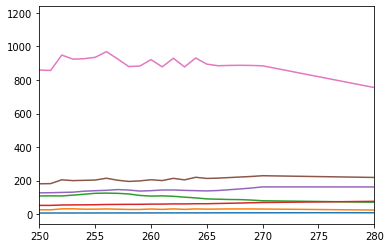

In [6]:
pl.plot(new_emissions['ssp585'])
pl.xlim(250,280)

## Solar radiation

In [7]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_erf = np.zeros((751))
solar_erf[:550] = df.solar_erf.loc[1750:2299].values
for scenario in scenarios:
    forcing[scenario]['solar']=solar_erf

## Volcanic forcing

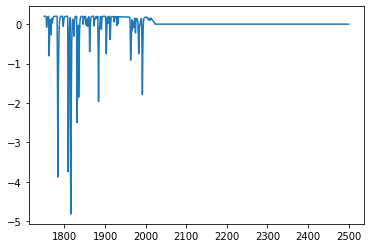

In [8]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_erf = np.zeros((751))
volcanic_erf[:265] = df.volcanic_erf.loc[1750:2014].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_erf[264:275] = volcanic_erf[264] * np.linspace(1,0,11)
volcanic_erf[275:] = 0.
pl.plot(np.arange(1750,2501), volcanic_erf[:])
#emissions = np.loadtxt('../data/SSP460_INTERIM_EMISSIONS.csv', skiprows=3, delimiter=',')

for scenario in scenarios:
    forcing[scenario]['volcanic']=volcanic_erf

## Aerosol forcing

In [9]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

samples = 100000

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.70/NINETY_TO_ONESIGMA, size=samples, random_state=31318990)

ERFari = np.zeros((270,samples))
ERFaci = np.zeros((270,samples))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()

for i in tqdm(range(samples), leave=False):
    ts2010 = np.mean(
        ghan(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
    )
    ts1750 = ghan(
        [
            so2[0],
                bc[0]+
                oc[0],
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
    )
    ERFaci[:,i] = (
        ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.70/NINETY_TO_ONESIGMA, size=samples, random_state=31318990)

array([-2.06081853, -1.75856508, -1.29949603, -0.84170183, -0.54289356])

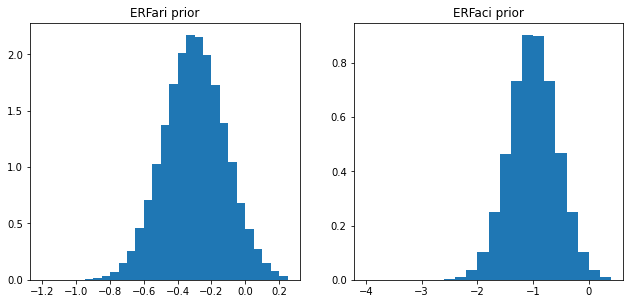

In [11]:
fig,ax = pl.subplots(1,2, figsize=(27/2.54,12/2.54))
ax[0].hist(ERFari_scale, bins=np.arange(-1.2,0.3,0.05), density=True);
ax[0].set_title('ERFari prior');
ax[1].hist(ERFaci_scale, bins=np.arange(-4,0.5,0.2), density=True);
ax[1].set_title('ERFaci prior');
np.percentile(ERFari_scale+ERFaci_scale, (5,16,50,84,95))

In [12]:
ERFari = {}
ERFaci = {}

bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[97])
nh3_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = nh3_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

for scenario in tqdm(scenarios):
    ERFari[scenario] = np.zeros((751,samples))
    ERFaci[scenario] = np.zeros((751,samples))
    
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    
    for i in tqdm(range(samples), leave=False):
        ERFari[scenario][:, i] = (
            (so2-so2[0]) * beta_so2[i] +
            (bc-bc[0]) * beta_bc[i] +
            (oc-oc[0]) * beta_oc[i] +
            (nh3-nh3[0]) * beta_nh3[i]
        )
    
    for i in tqdm(range(samples), leave=False):

        ts2010 = np.mean(
            ghan(
                [
                    so2[255:265],
                        bc[255:265]+
                        oc[255:265],
                ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
            )
        )
        ts1750 = ghan(
            [
                so2[0],
                    bc[0]+
                    oc[0],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
        ERFaci[scenario][:,i] = (
            ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
        - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
ERFari_median = {}
ERFaci_median = {}

for scenario in tqdm(scenarios):
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    
    beta_bc = 0.3/(np.mean(bc[255:265])-bc[0])
    beta_oc = -0.09/(np.mean(oc[255:265])-oc[0])
    beta_so2 = -0.4/(np.mean(so2[255:265])-so2[0])
    beta_nh3 = -0.11/(np.mean(nh3[255:265])-nh3[0])
    ERFaci_median[scenario] = np.percentile(ERFaci[scenario], 50, axis=1) * (-1.0)/(np.percentile(ERFaci[scenario], 50, axis=1)[255:265].mean())
    ERFari_median[scenario] = (
        (so2-so2[0]) * beta_so2 +
        (bc-bc[0]) * beta_bc +
        (oc-oc[0]) * beta_oc +
        (nh3-nh3[0]) * beta_nh3
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
for scenario in tqdm(scenarios):   
    forcing[scenario]['aerosol-radiation_interactions'] = ERFari_median[scenario]
    forcing[scenario]['aerosol-cloud_interactions'] = ERFaci_median[scenario]

  0%|          | 0/10 [00:00<?, ?it/s]

## BC on snow

Linear with emissions, 2019 = 0.08 in the historical from AR6

In [15]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/BC_global_CEDS_emissions_by_sector_2020_09_11.csv')
bc_hist = df.loc[:,'X1750':'X2019'].sum(axis=0).values/1000.

df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
bc_ar6_forc = df.loc[:,'bc_on_snow']

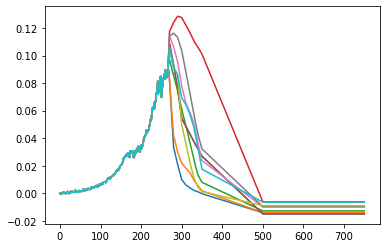

In [16]:
for scenario in scenarios:
    bc = new_emissions[scenario]['BC'].values.squeeze()
    forcing[scenario]['bc_on_snow'] = (bc-bc[0])/(bc_hist[264]-bc_hist[0])*bc_ar6_forc[264]
    pl.plot(forcing[scenario]['bc_on_snow'])

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

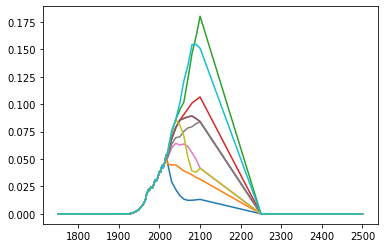

In [17]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/NOx_global_CEDS_emissions_by_sector_2020_09_11.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2019'].sum(axis=0).values/1000.
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
bc_ar6_forc = df.loc[:,'contrails']
for scenario in scenarios:
    avi_nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    avi_nox[:265] = avi_nox_hist[:265]
    avi_nox[265:270] = np.linspace(1,0.2,5) * avi_nox_hist[265:270] + np.linspace(0,0.8,5) * avi_nox[265:270]
    contrail_forcing_2014 = bc_ar6_forc[264]
    forcing[scenario]['contrails'] = avi_nox/avi_nox_hist[264] * contrail_forcing_2014
    pl.plot(np.arange(1750,2501), forcing[scenario]['contrails'])

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add --0.05 for irrigation

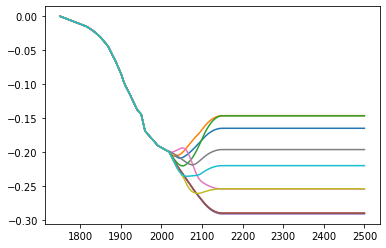

In [18]:
ghimire = pd.read_csv('../data_input/Ghimire_et_al_2014_GRL/ghimire_curve_fit.csv')
for scenario in scenarios:
    lusf2019 = -0.20/np.cumsum(emissions.loc[(emissions['Scenario']=='ssp245')&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values.squeeze())[269]  # include irrigation of -0.05 in Sherwood et al
    forcing[scenario]['land_use'] = np.cumsum(emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze())*lusf2019
    f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
    lusf2019 = -0.20/(f(2019)-f(1750))
    forcing[scenario]['land_use'][:269] = lusf2019*(f(np.arange(1750,2019))-f(1750))
    pl.plot(np.arange(1750, 2501), forcing[scenario]['land_use'])

## Greenhouse gas concentrations

For consistency I will use the observations for GHGs to 2014, and then ramp to SSPs in 2020.

In [19]:
ghg_obs = pd.read_excel('../data_input/observations/LLGHG_history_AR6_v9_updated.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
gases_obs = ghg_obs.columns.to_list()
gases_obs.remove('YYYY')
print(*(gases_obs))

gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

CO2 CH4 N2O HFC-134a HFC-23 HFC-32 HFC-125 HFC-143a HFC-152a HFC-227ea HFC-236fa HFC-245fa HFC-365mfc HFC-43-10mee NF3 SF6 SO2F2 CF4 C2F6 C3F8 c-C4F8 CFC-12 CFC-11 CFC-113 CFC-114 CFC-115 CFC-13 HCFC-22 HCFC-141b HCFC-142b CH3CCl3 CCl4 CH3Cl CH3Br CH2Cl2 CHCl3 Halon-1211 Halon-1301 Halon-2402 n-C4F10 n-C5F12 n-C6F14 i-C6F14 C7F16 C8F18 CFC-112 CFC-112a CFC-113a CFC-114a HCFC-133a HCFC-31 HCFC-124


  0%|          | 0/10 [00:00<?, ?it/s]

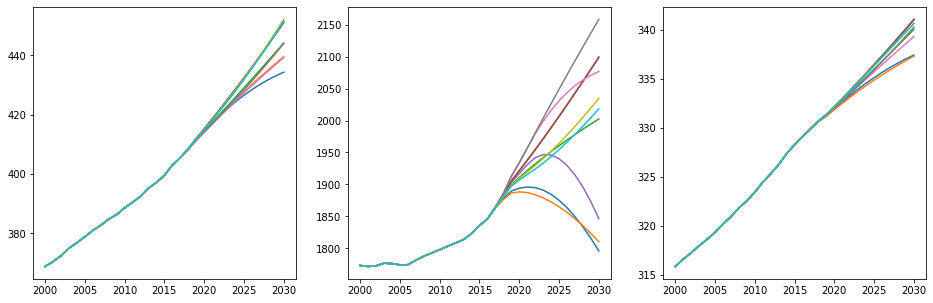

In [20]:
concentrations_out = {}

fig, ax = pl.subplots(1,3,figsize=(16,5))
for scenario in tqdm(scenarios):
    forcing[scenario]['co2'] = np.zeros(751)
    forcing[scenario]['ch4'] = np.zeros(751)
    forcing[scenario]['n2o'] = np.zeros(751)

    concentrations_out[scenario] = {}
    concentrations_out[scenario]['CO2'] = np.zeros(751)
    concentrations_out[scenario]['CH4'] = np.zeros(751)
    concentrations_out[scenario]['N2O'] = np.zeros(751)

    co2 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CO2')),'1750':'2500'].values.squeeze()
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
    co2[:265] = ghg_obs['CO2'].values[:265]
    ch4[:265] = ghg_obs['CH4'].values[:265]
    n2o[:265] = ghg_obs['N2O'].values[:265]
    
    co2[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CO2'].values[264:270] + np.linspace(0,1,6) * co2[264:270]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
    
    concentrations_out[scenario]['CO2'] = co2
    concentrations_out[scenario]['CH4'] = ch4
    concentrations_out[scenario]['N2O'] = n2o
    
    for i, year in enumerate(range(1750,2501)):
        forcing[scenario]['co2'][i], forcing[scenario]['ch4'][i], forcing[scenario]['n2o'][i] = meinshausen( #etminan(
            [co2[i], ch4[i], n2o[i]], 
            [co2[0], ch4[0], n2o[0]], scale_F2x=False)

    # include rapid adjustments for CO2, CH4 and N2O:
    forcing[scenario]['co2'] = 1.05 * forcing[scenario]['co2']
    forcing[scenario]['ch4'] = 0.86 * forcing[scenario]['ch4']
    forcing[scenario]['n2o'] = 1.07 * forcing[scenario]['n2o']
    
    ax[0].plot(np.arange(2000,2031), co2[250:281])
    ax[1].plot(np.arange(2000,2031),ch4[250:281])
    ax[2].plot(np.arange(2000,2031),n2o[250:281])

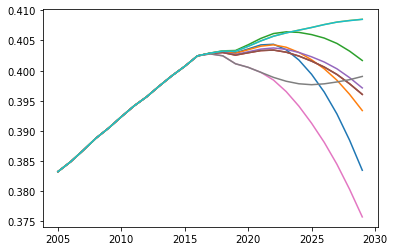

In [21]:
gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

trop_adjustment_scale = radeff.copy()
for key in trop_adjustment_scale.keys():
    trop_adjustment_scale[key] = 1
trop_adjustment_scale['CFC-11'] = 1.13
trop_adjustment_scale['CFC-12'] = 1.12

for scenario in scenarios:
    forcing[scenario]['other_wmghg'] = np.zeros(751)
    for gas in gases_obs[3:]:
        meins = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(ghg_to_rcmip_names[gas])),'1750':'2500'].values.squeeze()
        if meins.shape == (0,751):
            meins = np.zeros(751)
        obs = ghg_obs[gas].values[:270]
        conc = np.zeros(751)
        conc[:265] = obs[:265]
        conc[264:270] = np.linspace(1.0,0.0,6) * obs[264:270] + np.linspace(0,1,6) * meins[264:270]
        conc[270:] = meins[270:]
        concentrations_out[scenario][gas] = conc
        forcing[scenario][gas] = ((conc - conc[0]) * radeff[gas] * 0.001) * trop_adjustment_scale[gas]
        forcing[scenario]['other_wmghg'] = forcing[scenario]['other_wmghg'] + forcing[scenario][gas]
    pl.plot(np.arange(2005,2030), forcing[scenario]['other_wmghg'][255:280])

## Stratospheric water vapour

In [22]:
forcing_ar6 = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')

for scenario in scenarios:
    forcing[scenario]['h2o_stratospheric'] = forcing[scenario]['ch4']/(forcing_ar6['ch4'].values[269] - forcing_ar6['ch4'].values[0]) * 0.05

## Ozone: including a temperature feedback adjustment

Follow Skeie (AR6) for 1750-2014, then use emissions-based relationships based on Stevenson et al. and updated coefficients from AerChemMIP, including the temperature feedback on ozone forcing (see 024)

Add in a temperature dependence from Thornhill et al. 2021b of -0.037 +/- 0.012 W m-2 K-1

1. sum up forcing
2. run two-layer model and save temperature results
3. calculate adjustment to ozone forcing

In [23]:
o3_df = pd.read_csv('../data_output/o3_erf.csv')
skeie_total = o3_df['o3_erf'].values[:270]

o3_coeffs = pd.read_csv('../data_input/tunings/cmip6_ozone_skeie_fits.csv', index_col=0)
ozone_rad_eff = o3_coeffs['mean']

  0%|          | 0/10 [00:00<?, ?it/s]

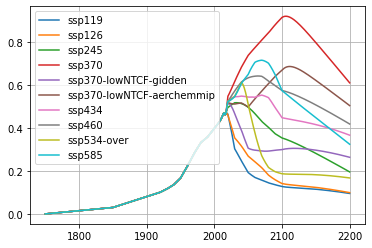

In [24]:
for scenario in tqdm(scenarios):
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    ch4[:265] = ghg_obs['CH4'].values[:265]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
    n2o[:265] = ghg_obs['N2O'].values[:265]
    n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
    ods = np.zeros((751))
    for specie in ods_species:
        this_ods = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(specie)),'1750':'2500'].values.squeeze()
        this_ods[:265] = ghg_obs.loc[:2014,rcmip_to_ghg_names[specie]].values.squeeze()
        this_ods[264:270] = np.linspace(1.0,0.0,6) * ghg_obs.loc[2014:2019,rcmip_to_ghg_names[specie]].values.squeeze() + np.linspace(0,1,6) * this_ods[264:270]
        ods = ods + (eesc(this_ods, specie))
    co = new_emissions[scenario]['CO']
    nox = new_emissions[scenario]['NOx']
    voc = new_emissions[scenario]['VOC']

#     ozone_rad_eff = {
#         'CH4' : 2.33379720e-04,
#         'N2O' : 1.27179106e-03,
#         'ODS' : -6.69347820e-05,
#         'CO' : 1.14647701e-04,
#         'VOC' : 5.14366051e-12,
#         'NOx' : 1.15151346e-03
#     }

    forcing[scenario]['o3'] = np.zeros(751)
    
    forcing[scenario]['o3'][:265] = skeie_total[:265]
    
    forcing[scenario]['o3'][265:] = (
        ozone_rad_eff['CH4'] * (ch4[265:]-ch4[0]) +
        ozone_rad_eff['N2O'] * (n2o[265:]-n2o[0]) +
        ozone_rad_eff['ODS'] * (ods[265:]-ods[0]) +
        ozone_rad_eff['CO'] * (co[265:]-co[0]) +
        ozone_rad_eff['VOC'] * (voc[265:]-voc[0]) +
        ozone_rad_eff['NOx'] * (nox[265:]-nox[0])
    ).values
    
    forcing[scenario]['o3'][264:270] = np.linspace(1.0,0.0,6) * skeie_total[264:270] + np.linspace(0,1,6) * forcing[scenario]['o3'][264:270]
    
    pl.plot(np.arange(1750,2201), forcing[scenario]['o3'][:451], label=scenario)
pl.grid()
pl.legend()

In [25]:
with open("../data_input/tunings/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)

xl = pd.read_excel('../data_input/observations/AR6 FGD assessment time series - GMST and GSAT.xlsx', skiprows=1, skipfooter=28)
Tobs=xl['4-set mean'].values
#years=xl['Unnamed: 0'].values

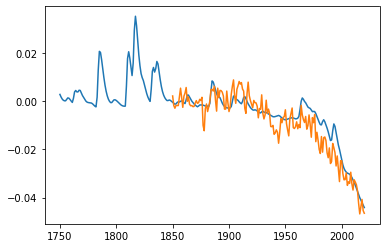

In [26]:
scenario='ssp245'

#dl = cmip6_models['dl']['mean'] * ur(cmip6_models['dl']['units'])
#du = cmip6_models['du']['mean']  * ur(cmip6_models['du']['units'])
#eta = cmip6_models['eta']['mean'] * ur(cmip6_models['eta']['units'])
#lambda0 = 4/3 *  ur(cmip6_models['lambda0']['units'])
#efficacy = cmip6_models['efficacy']['mean'] * ur(cmip6_models['efficacy']['units'])

cmix = cmip6_models['cmix']['mean']['EBM-epsilon']
cdeep = cmip6_models['cdeep']['mean']['EBM-epsilon']
#gamma_2l = cmip6_models['gamma_2l']['mean']['EBM-epsilon']
#lamg = -cmip6_models['lamg']['mean']['EBM-epsilon']
eff = cmip6_models['eff']['mean']['EBM-epsilon']

f2x = 4.0
ecs = 3.0
tcr = 1.8
lamg = f2x/ecs
kappa = -(f2x/ecs - f2x/tcr)
gamma_2l = kappa/eff

# 1. sum up forcing including no-feedback ozone forcing
forcing[scenario]['total_anthropogenic']=forcing[scenario]['co2']+forcing[scenario]['ch4']+forcing[scenario]['n2o']+\
    forcing[scenario]['other_wmghg']+\
    forcing[scenario]['o3']+forcing[scenario]['h2o_stratospheric']+forcing[scenario]['contrails']+\
    forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions']+forcing[scenario]['bc_on_snow']+forcing[scenario]['land_use']
forcing[scenario]['total_natural']=forcing[scenario]['volcanic']+forcing[scenario]['solar']
forcing[scenario]['total']=forcing[scenario]['total_anthropogenic']+forcing[scenario]['total_natural']
erf0 = forcing[scenario]['total']

# 2. run two layer model and save temperature results
driver = TwoLayerModel(
    extforce=erf0,
    exttime=np.arange(1750,2501),
    tbeg=1750,
    tend=2500,
    lamg=lamg,
    t2x=None,
    eff=eff,
    cmix=cmix,
    cdeep=cdeep,
    gamma_2l=gamma_2l,
    outtime=np.arange(1750,2501),
    dt=0.2
)
output = driver.run()

temp0 = output.tg

pl.plot(np.arange(1750,2021), -0.037*(temp0[:271]-temp0[100:151].mean()))
pl.plot(np.arange(1850,2021), -0.037*Tobs)

Scenarios:   0%|          | 0/10 [00:00<?, ?it/s]

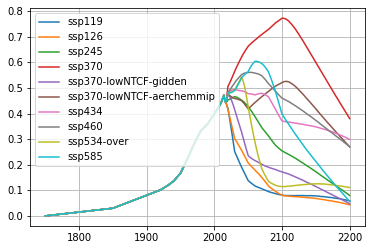

In [27]:
for scenario in tqdm(scenarios, desc="Scenarios"):
    for i in range(10):
        # 1. sum up forcing including no-feedback ozone forcing
        forcing[scenario]['total_anthropogenic']=forcing[scenario]['co2']+forcing[scenario]['ch4']+forcing[scenario]['n2o']+\
            forcing[scenario]['other_wmghg']+\
            forcing[scenario]['o3']+forcing[scenario]['h2o_stratospheric']+forcing[scenario]['contrails']+\
            forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions']+forcing[scenario]['bc_on_snow']+forcing[scenario]['land_use']
        forcing[scenario]['total_natural']=forcing[scenario]['volcanic']+forcing[scenario]['solar']
        forcing[scenario]['total']=forcing[scenario]['total_anthropogenic']+forcing[scenario]['total_natural']
        erf0 = forcing[scenario]['total']

        # 2. run two layer model and save temperature results
        driver = TwoLayerModel(
            extforce=erf0,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2500,
            lamg=lamg,
            t2x=None,
            eff=eff,
            cmix=cmix,
            cdeep=cdeep,
            gamma_2l=gamma_2l,
            outtime=np.arange(1750,2501),
            dt=0.2
        )
        output = driver.run()
        temp0 = output.tg
        ozone_feedback = -0.037 * (temp0-temp0[100:151].mean())

        ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
        ch4[:265] = ghg_obs['CH4'].values[:265]
        ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
        n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
        n2o[:265] = ghg_obs['N2O'].values[:265]
        n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
        ods = np.zeros((751))
        for specie in ods_species:
            this_ods = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(specie)),'1750':'2500'].values.squeeze()
            this_ods[:265] = ghg_obs.loc[:2014,rcmip_to_ghg_names[specie]].values.squeeze()
            this_ods[264:270] = np.linspace(1.0,0.0,6) * ghg_obs.loc[2014:2019,rcmip_to_ghg_names[specie]].values.squeeze() + np.linspace(0,1,6) * this_ods[264:270]
            ods = ods + (eesc(this_ods, specie))
        co = new_emissions[scenario]['CO']
        nox = new_emissions[scenario]['NOx']
        voc = new_emissions[scenario]['VOC']

        forcing[scenario]['o3'][:265] = skeie_total[:265]

        forcing[scenario]['o3'][265:] = (
            ozone_rad_eff['CH4'] * (ch4[265:]-ch4[0]) +
            ozone_rad_eff['N2O'] * (n2o[265:]-n2o[0]) +
            ozone_rad_eff['ODS'] * (ods[265:]-ods[0]) +
            ozone_rad_eff['CO'] * (co[265:]-co[0]) +
            ozone_rad_eff['VOC'] * (voc[265:]-voc[0]) +
            ozone_rad_eff['NOx'] * (nox[265:]-nox[0])
        ).values + ozone_feedback[265:]

        forcing[scenario]['o3'][264:270] = np.linspace(1.0,0.0,6) * skeie_total[264:270] + np.linspace(0,1,6) * forcing[scenario]['o3'][264:270]
        
    pl.plot(np.arange(1750, 2201), forcing[scenario]['o3'][:451], label=scenario)
pl.grid()
pl.legend()

In [28]:
colors = {
    'ssp119': '#1e9583',
    'ssp126': '#1d3354',
    'ssp245': '#e9dc3d',  # WHY is ssp245 yellow? This infuriates me
    'ssp370': '#f11111',
    'ssp370-lowNTCF-gidden': '#f11111', 
    'ssp370-lowNTCF-aerchemmip': '#f11111',
    'ssp434': '#63bce4',
    'ssp460': '#e78731',
    'ssp534-over': '#996dc8',
    'ssp585': '#830b22',
}

ls = {
    'ssp119': '-',
    'ssp126': '-',
    'ssp245': '-', 
    'ssp370': '-',
    'ssp370-lowNTCF-gidden': '--', 
    'ssp370-lowNTCF-aerchemmip': '-.',
    'ssp434': '-',
    'ssp460': '-',
    'ssp534-over': '-',
    'ssp585': '-',
}

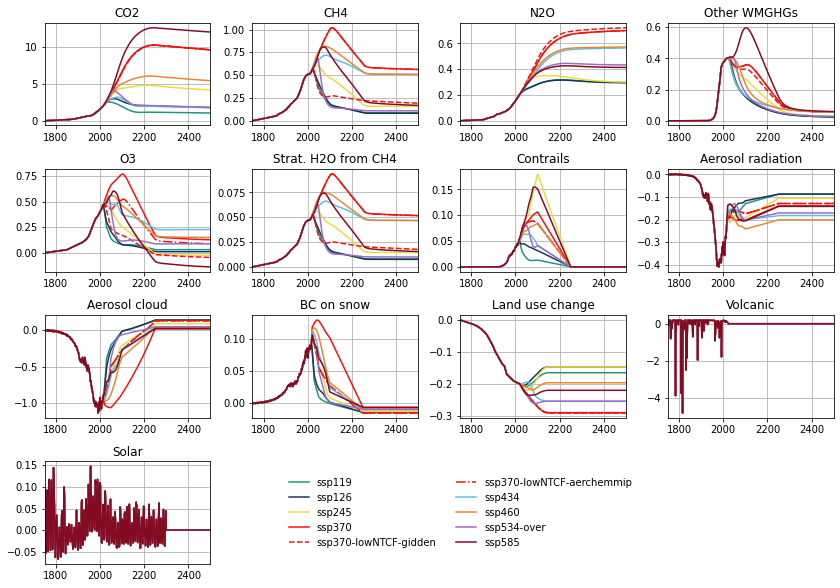

In [29]:
fig, ax = pl.subplots(4,4, figsize=(29.7/2.54,21/2.54),squeeze=True)
for scenario in scenarios:
    ax[0,0].plot(np.arange(1750,2501),forcing[scenario]['co2'], color=colors[scenario], ls=ls[scenario])
    ax[0,1].plot(np.arange(1750,2501),forcing[scenario]['ch4'], color=colors[scenario], ls=ls[scenario])
    ax[0,2].plot(np.arange(1750,2501),forcing[scenario]['n2o'], color=colors[scenario], ls=ls[scenario])
    ax[0,3].plot(np.arange(1750,2501),forcing[scenario]['other_wmghg'], color=colors[scenario], ls=ls[scenario])
    ax[1,0].plot(np.arange(1750,2501),forcing[scenario]['o3'], color=colors[scenario], ls=ls[scenario])
    ax[1,1].plot(np.arange(1750,2501),forcing[scenario]['h2o_stratospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,2].plot(np.arange(1750,2501),forcing[scenario]['contrails'], color=colors[scenario], ls=ls[scenario])
    ax[1,3].plot(np.arange(1750,2501),forcing[scenario]['aerosol-radiation_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,0].plot(np.arange(1750,2501),forcing[scenario]['aerosol-cloud_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,1].plot(np.arange(1750,2501),forcing[scenario]['bc_on_snow'], color=colors[scenario], ls=ls[scenario])
    ax[2,2].plot(np.arange(1750,2501),forcing[scenario]['land_use'], color=colors[scenario], ls=ls[scenario])
    ax[2,3].plot(np.arange(1750,2501),forcing[scenario]['volcanic'], color=colors[scenario], ls=ls[scenario])
    ax[3,0].plot(np.arange(1750,2501),forcing[scenario]['solar'], color=colors[scenario], ls=ls[scenario], label=scenario)

ax[3,1].axis('off')
ax[3,2].axis('off')
ax[3,3].axis('off')
ax[0,0].set_xlim(1750,2500)
ax[0,1].set_xlim(1750,2500)
ax[0,2].set_xlim(1750,2500)
ax[0,3].set_xlim(1750,2500)
ax[1,0].set_xlim(1750,2500)
ax[1,1].set_xlim(1750,2500)
ax[1,2].set_xlim(1750,2500)
ax[1,3].set_xlim(1750,2500)
ax[2,0].set_xlim(1750,2500)
ax[2,1].set_xlim(1750,2500)
ax[2,2].set_xlim(1750,2500)
ax[2,3].set_xlim(1750,2500)
ax[3,0].set_xlim(1750,2500)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[0,3].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
ax[1,3].grid()
ax[2,0].grid()
ax[2,1].grid()
ax[2,2].grid()
ax[2,3].grid()
ax[3,0].grid()
ax[0,0].set_title('CO2')
ax[0,1].set_title('CH4')
ax[0,2].set_title('N2O')
ax[0,3].set_title('Other WMGHGs')
ax[1,0].set_title('O3')
ax[1,1].set_title('Strat. H2O from CH4')
ax[1,2].set_title('Contrails')
ax[1,3].set_title('Aerosol radiation')
ax[2,0].set_title('Aerosol cloud')
ax[2,1].set_title('BC on snow')
ax[2,2].set_title('Land use change')
ax[2,3].set_title('Volcanic')
ax[3,0].set_title('Solar')
pl.tight_layout()
ax[3,0].legend(bbox_to_anchor=[3.6,0.5], frameon=False, ncol=2, loc='center right')
#pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/components.png')

In [30]:
for scenario in scenarios:
    forcing[scenario]['total_anthropogenic']=forcing[scenario]['co2']+forcing[scenario]['ch4']+forcing[scenario]['n2o']+\
        forcing[scenario]['other_wmghg']+\
        forcing[scenario]['o3']+forcing[scenario]['h2o_stratospheric']+forcing[scenario]['contrails']+\
        forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions']+forcing[scenario]['bc_on_snow']+forcing[scenario]['land_use']
    forcing[scenario]['total_natural']=forcing[scenario]['volcanic']+forcing[scenario]['solar']
    forcing[scenario]['total']=forcing[scenario]['total_anthropogenic']+forcing[scenario]['total_natural']

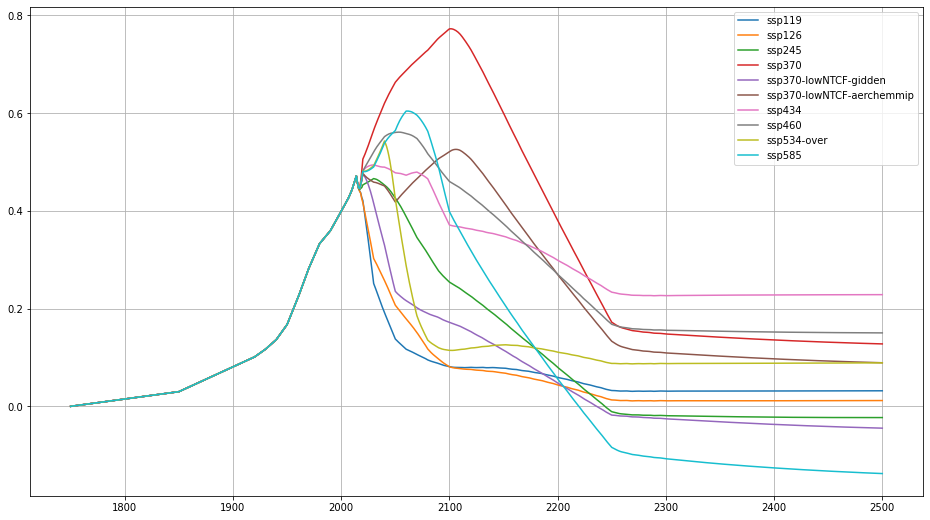

In [31]:
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1750,2501), forcing[scenario]['o3'], label=scenario)
pl.grid()
pl.legend()

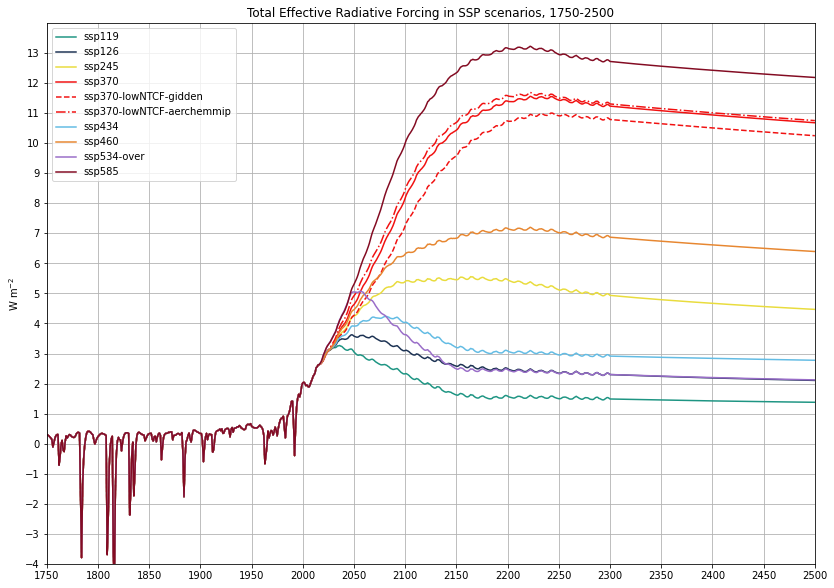

In [32]:
pl.figure(figsize=(29.7/2.54,21/2.54))
for scenario in scenarios:
    pl.plot(np.arange(1750,2501), forcing[scenario]['total'], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.yticks(np.arange(-4,14))
pl.xticks(np.arange(1750,2501,50))
pl.ylim(-4,14)
pl.xlim(1750,2500)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1750-2500')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/total.png')

In [33]:
mkdir_p('../data_output/SSPs/')

for scenario in scenarios:
    df = pd.DataFrame(data=forcing[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df=df[['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
      'volcanic','solar','total_anthropogenic','total_natural','total']]
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df.to_csv('../data_output/SSPs/ERF_%s_1750-2500.csv' % outname)#
    df = pd.DataFrame(data=forcing[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df=df[gases_obs[3:]]
    df.to_csv('../data_output/SSPs/ERF_%s_minorGHGs_1750-2500.csv' % outname)
    df = new_emissions[scenario]
    df.index = np.arange(1750,2501)
    df.index.name='year'
    df.to_csv('../data_output_large/SSPs/emissions_%s_1750-2500.csv' % outname)
    df = pd.DataFrame(data=concentrations_out[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df.to_csv('../data_output_large/SSPs/conc_%s_1750-2500.csv' % outname)
df

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
1750,278.300000,729.200000,270.100000,0.0,0.00000,0.000218,0.000000,0.000000,0.0,0.000004,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1751,278.372000,729.984000,270.120000,0.0,0.00000,0.000218,0.000000,0.000000,0.0,0.000004,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1752,278.444000,730.768000,270.140000,0.0,0.00000,0.000218,0.000000,0.000000,0.0,0.000004,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1753,278.516000,731.552000,270.160000,0.0,0.00000,0.000218,0.000000,0.000000,0.0,0.000004,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754,278.588000,732.336000,270.180000,0.0,0.00000,0.000218,0.000000,0.000000,0.0,0.000004,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2012.339996,1019.619939,406.631981,0.0,2.17850,0.000000,0.001263,0.219431,0.0,0.000078,...,0.0,0.266080,0.138398,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,2011.669993,1019.449941,406.624982,0.0,2.16480,0.000000,0.001205,0.213379,0.0,0.000075,...,0.0,0.265991,0.138352,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2011.010000,1019.279933,406.616987,0.0,2.15120,0.000000,0.001149,0.207494,0.0,0.000072,...,0.0,0.265902,0.138306,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df.loc[2000:2020]

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
2000,368.830000,1773.143000,315.879000,14.217500,15.172000,0.209805,1.473000,2.449000,1.570000,0.113000,...,0.0380,0.069750,0.062500,0.4825,0.0730,0.33100,1.033000,0.112530,0.0270,0.000
2001,370.410000,1771.652000,316.623500,17.727500,15.863000,0.277602,1.865500,2.923000,1.820000,0.141000,...,0.0000,0.073350,0.067000,0.4770,0.0720,0.34400,1.031625,0.115320,0.0290,0.000
2002,372.420000,1772.554000,317.271500,21.557500,16.547000,0.378382,2.295000,3.483000,2.180000,0.173000,...,0.0000,0.076500,0.071000,0.4710,0.0700,0.35700,1.027527,0.124620,0.0320,0.000
2003,374.970000,1776.749500,317.982500,25.701500,17.263000,0.517642,2.814500,4.097500,2.590000,0.208000,...,0.0000,0.080100,0.074500,0.4655,0.0680,0.37025,1.023429,0.136710,0.0350,0.000
2004,376.790000,1776.124000,318.637500,29.996000,18.111000,0.766843,3.365500,4.818500,3.133000,0.251000,...,0.0000,0.083250,0.077000,0.4605,0.0670,0.38400,1.027000,0.163680,0.0380,1.250
2005,378.820000,1774.142000,319.348500,34.545000,19.064000,1.107661,3.965000,5.622500,3.697000,0.304000,...,0.0000,0.086400,0.080000,0.4560,0.0670,0.39800,1.045000,0.203670,0.0420,1.300
2006,380.960000,1774.364000,320.190500,38.905000,20.116000,1.476882,4.637500,6.538500,4.365000,0.365000,...,0.0000,0.089550,0.081500,0.4530,0.0660,0.40625,1.027000,0.247380,0.0480,1.320
2007,382.690000,1781.297500,320.941500,43.309000,21.025000,1.956044,5.497500,7.504500,5.111000,0.430000,...,0.0000,0.092700,0.083500,0.4510,0.0660,0.40750,1.026000,0.286440,0.0580,1.350
2008,384.790000,1787.747000,321.848500,47.832500,21.854000,2.465440,6.492000,8.592000,5.698500,0.498000,...,0.0000,0.096300,0.085000,0.4490,0.0660,0.40750,1.036000,0.293880,0.0690,1.250


## Uncertainties

In [35]:
# check aerosol ensemble ranges are correct
print(np.percentile(ERFari['ssp245'][255:265,:].mean(axis=0), (5,50,95)))
print(np.percentile(ERFaci['ssp245'][255:265,:].mean(axis=0), (5,50,95)))

[-0.59478952 -0.2992903  -0.00626754]
[-1.70055162 -0.99997523 -0.2991714 ]


In [36]:
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(samples,11), loc=np.ones((samples,11)), scale=np.ones((samples, 11)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,7]<1,7] = 0.08/0.1*(scale[scale[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale[scale[:,6]<1,6] = 0.0384/0.0406*(scale[scale[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=samples, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=138294)
#trend_solar[trend_solar>-0.01] = 11/4 * (trend_solar[trend_solar>-0.01]+0.01)-0.01

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

In [37]:
forcing_ensemble = {}

for scenario in tqdm(scenarios, desc='scenario'):
    forcing_ensemble[scenario] = {}
    for cat in tqdm(['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow',
               'land_use','volcanic'], leave=False, desc='category'):
        forcing_ensemble[scenario][cat] = forcing[scenario][cat][:,None] * scale_df['co2'].values[None,:]
    forcing_ensemble[scenario]['aerosol-radiation_interactions'] = ERFari[scenario]
    forcing_ensemble[scenario]['aerosol-cloud_interactions'] = ERFaci[scenario]
    forcing_ensemble[scenario]['solar'] = np.zeros((751, samples))
    forcing_ensemble[scenario]['solar'][:270, :] = np.linspace(0, trend_solar, 270) + solar_erf[:270, None] * scale_df['solar'].values[None,:]
    forcing_ensemble[scenario]['solar'][270:, :] = trend_solar + solar_erf[270:, None] * scale_df['solar'].values[None,:]
    forcing_ensemble[scenario]['total_anthropogenic'] = (
        forcing_ensemble[scenario]['co2'] +
        forcing_ensemble[scenario]['ch4'] +
        forcing_ensemble[scenario]['n2o'] +
        forcing_ensemble[scenario]['other_wmghg'] +
        forcing_ensemble[scenario]['o3'] + 
        forcing_ensemble[scenario]['h2o_stratospheric'] + 
        forcing_ensemble[scenario]['contrails'] + 
        forcing_ensemble[scenario]['bc_on_snow'] +
        forcing_ensemble[scenario]['land_use'] +
        forcing_ensemble[scenario]['aerosol-radiation_interactions'] + 
        forcing_ensemble[scenario]['aerosol-cloud_interactions']
    )
    forcing_ensemble[scenario]['total_natural'] = (
        forcing_ensemble[scenario]['solar'] +
        forcing_ensemble[scenario]['volcanic']
    )
    forcing_ensemble[scenario]['total'] = (
        forcing_ensemble[scenario]['co2'] +
        forcing_ensemble[scenario]['ch4'] +
        forcing_ensemble[scenario]['n2o'] +
        forcing_ensemble[scenario]['other_wmghg'] +
        forcing_ensemble[scenario]['o3'] + 
        forcing_ensemble[scenario]['h2o_stratospheric'] + 
        forcing_ensemble[scenario]['contrails'] + 
        forcing_ensemble[scenario]['bc_on_snow'] +
        forcing_ensemble[scenario]['land_use'] +
        forcing_ensemble[scenario]['aerosol-radiation_interactions'] + 
        forcing_ensemble[scenario]['aerosol-cloud_interactions'] +
        forcing_ensemble[scenario]['solar'] +
        forcing_ensemble[scenario]['volcanic']
    )

scenario:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

category:   0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
for scenario in tqdm(scenarios):
    df = pd.DataFrame(data=np.array([
        np.percentile(forcing_ensemble[scenario]['co2'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['ch4'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['n2o'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['other_wmghg'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['o3'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['h2o_stratospheric'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['contrails'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['aerosol-radiation_interactions'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['aerosol-cloud_interactions'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['bc_on_snow'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['land_use'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['volcanic'],5,axis=1),    
        np.percentile(forcing_ensemble[scenario]['solar'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['total_anthropogenic'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['total_natural'],5,axis=1),
        np.percentile(forcing_ensemble[scenario]['total'],5,axis=1)
    ]).T, index=np.arange(1750,2501))
    df.index.name = 'year'
    df = df.rename(columns={
        0: 'co2',
        1: 'ch4',
        2: 'n2o',
        3: 'other_wmghg',
        4: 'o3',
        5: 'h2o_stratospheric',
        6: 'contrails',
        7: 'aerosol-radiation_interactions',
        8: 'aerosol-cloud_interactions',
        9:'bc_on_snow',
        10:'land_use',
        11:'volcanic',
        12:'solar',
        13:'total_anthropogenic',
        14:'total_natural',
        15:'total'
    })
    
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df.to_csv('../data_output/SSPs/ERF_%s_1750-2500_pc05.csv' % outname)
df

  0%|          | 0/10 [00:00<?, ?it/s]

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.176030,0.049109,0.000000,0.243696,0.243696
1751,0.001246,0.000447,0.000065,7.005019e-10,0.000264,0.000041,0.0,-0.000900,0.000782,-0.000401,-0.000256,0.176041,0.039908,0.002772,0.233296,0.240789
1752,0.002493,0.000895,0.000130,1.401004e-09,0.000528,0.000082,0.0,-0.001034,0.001184,-0.000540,-0.000513,0.176045,0.024790,0.005623,0.215097,0.227019
1753,0.003739,0.001341,0.000195,2.101506e-09,0.000792,0.000123,0.0,-0.001005,0.000773,-0.000417,-0.000769,0.176046,0.006597,0.006839,0.188313,0.199016
1754,0.004984,0.001788,0.000260,2.802008e-09,0.001056,0.000164,0.0,-0.001423,-0.005962,0.000020,-0.001026,0.176046,-0.032069,0.001502,0.152309,0.156404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,10.580932,0.148544,0.364511,5.222185e-02,-0.153527,0.013653,0.0,-0.201055,0.004987,-0.007176,-0.246489,0.000000,-0.059958,10.727111,-0.059958,10.735121
2497,10.579152,0.148465,0.364506,5.219165e-02,-0.153627,0.013646,0.0,-0.201055,0.004987,-0.007176,-0.246489,0.000000,-0.059958,10.725132,-0.059958,10.733141
2498,10.577398,0.148385,0.364497,5.216160e-02,-0.153728,0.013639,0.0,-0.201055,0.004987,-0.007176,-0.246489,0.000000,-0.059958,10.723158,-0.059958,10.731185


In [39]:
for scenario in tqdm(scenarios):
    df = pd.DataFrame(data=np.array([
        np.percentile(forcing_ensemble[scenario]['co2'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['ch4'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['n2o'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['other_wmghg'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['o3'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['h2o_stratospheric'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['contrails'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['aerosol-radiation_interactions'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['aerosol-cloud_interactions'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['bc_on_snow'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['land_use'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['volcanic'],95,axis=1),    
        np.percentile(forcing_ensemble[scenario]['solar'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['total_anthropogenic'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['total_natural'],95,axis=1),
        np.percentile(forcing_ensemble[scenario]['total'],95,axis=1)
    ]).T, index=np.arange(1750,2501))
    df.index.name = 'year'
    df = df.rename(columns={
        0: 'co2',
        1: 'ch4',
        2: 'n2o',
        3: 'other_wmghg',
        4: 'o3',
        5: 'h2o_stratospheric',
        6: 'contrails',
        7: 'aerosol-radiation_interactions',
        8: 'aerosol-cloud_interactions',
        9:'bc_on_snow',
        10:'land_use',
        11:'volcanic',
        12:'solar',
        13:'total_anthropogenic',
        14:'total_natural',
        15:'total'
    })
    
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df.to_csv('../data_output/SSPs/ERF_%s_1750-2500_pc95.csv' % outname)
df

  0%|          | 0/10 [00:00<?, ?it/s]

,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.223879,0.146720,0.000000,0.352053,0.352053
1751,0.001585,0.000569,0.000083,8.909136e-10,0.000336,0.000052,0.0,0.002114,0.014754,-0.000316,-0.000202,0.223893,0.119186,0.017184,0.325678,0.334766
1752,0.003170,0.001138,0.000166,1.781827e-09,0.000672,0.000105,0.0,0.003552,0.023209,-0.000425,-0.000403,0.223897,0.073971,0.028307,0.283536,0.300233
1753,0.004755,0.001706,0.000248,2.672741e-09,0.001008,0.000157,0.0,0.002093,0.015083,-0.000328,-0.000605,0.223899,0.019683,0.021687,0.237889,0.252308
1754,0.006339,0.002274,0.000331,3.563654e-09,0.001343,0.000209,0.0,-0.000331,-0.000392,0.000025,-0.000807,0.223900,-0.010594,0.007654,0.204983,0.211223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,13.457060,0.188921,0.463593,6.641688e-02,-0.120714,0.017365,0.0,-0.082038,0.078124,-0.005642,-0.193808,0.000000,0.079638,13.678091,0.079638,13.690758
2497,13.454796,0.188821,0.463586,6.637848e-02,-0.120793,0.017355,0.0,-0.082038,0.078124,-0.005642,-0.193808,0.000000,0.079638,13.675564,0.079638,13.688237
2498,13.452565,0.188720,0.463575,6.634026e-02,-0.120872,0.017346,0.0,-0.082038,0.078124,-0.005642,-0.193808,0.000000,0.079638,13.673066,0.079638,13.685746


In [40]:
df_obs = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv', index_col=0)

In [41]:
pl.rcParams['font.size'] = 16

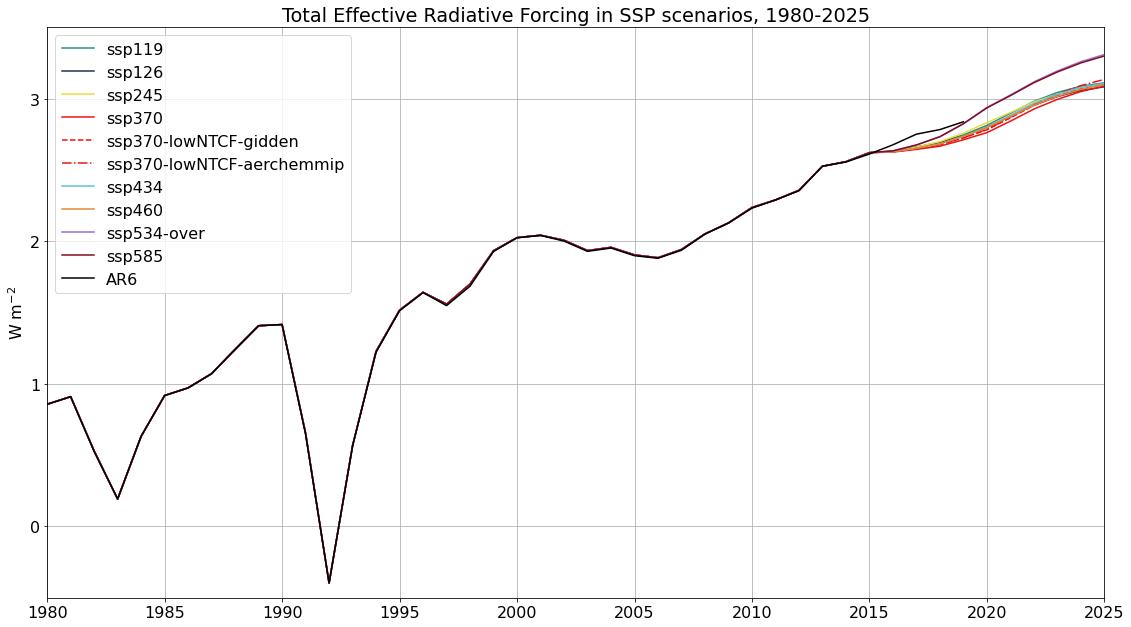

In [42]:
#pl.figure(figsize=(29.7/2.54,21/2.54))
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1980,2026), forcing[scenario]['total'][230:276], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1980,2020), df_obs['total'].loc[1980:2020], color='k', label='AR6')
pl.yticks(np.arange(-4,14))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-0.5,3.5)
pl.xlim(1980,2025)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1980-2025')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')

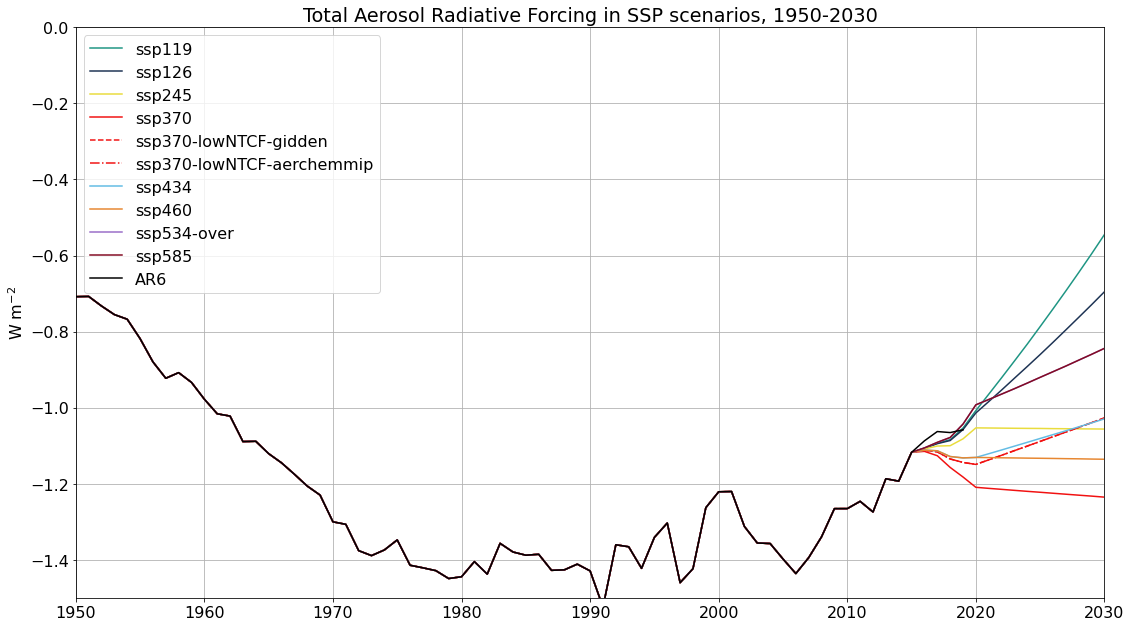

In [43]:
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1950,2031), forcing[scenario]['aerosol-radiation_interactions'][200:281]+forcing[scenario]['aerosol-cloud_interactions'][200:281], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1950,2020), df_obs['aerosol-radiation_interactions'].loc[1950:2020]+df_obs['aerosol-cloud_interactions'].loc[1950:2020], color='k', label='AR6')
#pl.yticks(np.arange(-1.5,0.25))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-1.5,0)
pl.xlim(1950,2030)
pl.legend()
pl.grid()
pl.title('Total Aerosol Radiative Forcing in SSP scenarios, 1950-2030')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')

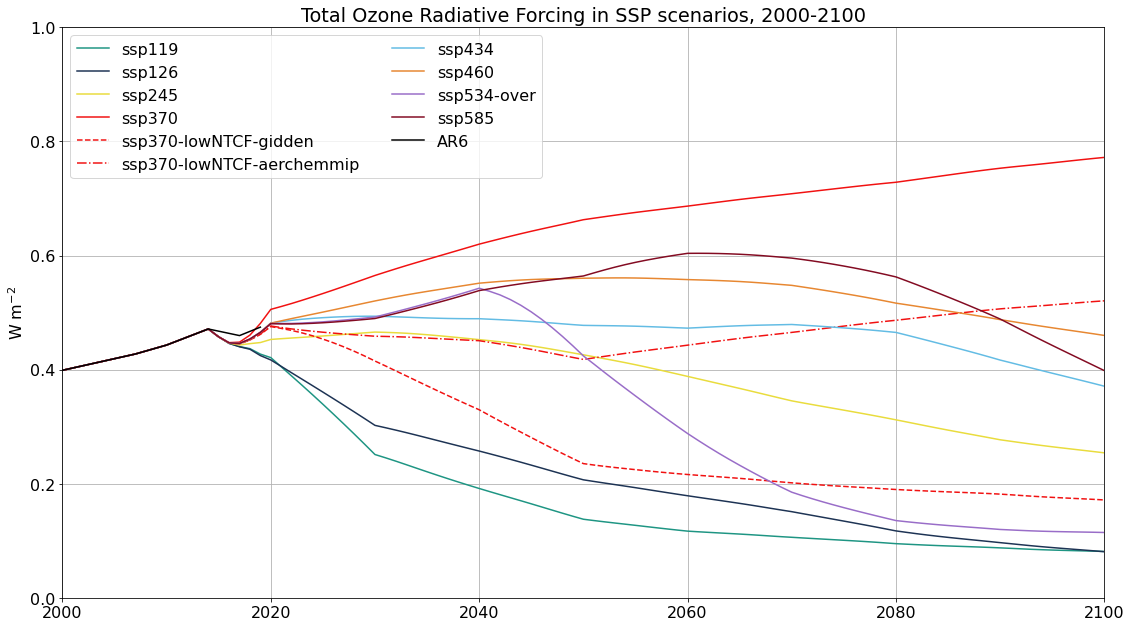

In [44]:
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(2000,2101), forcing[scenario]['o3'][250:351], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(2000,2020), df_obs['o3'].loc[2000:2019], color='k', label='AR6')
#pl.yticks(np.arange(-1.5,0.25))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(0,1.0)
pl.xlim(2000,2100)
pl.legend(ncol=2)
pl.grid()
pl.title('Total Ozone Radiative Forcing in SSP scenarios, 2000-2100')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')

In [45]:
forcing_ensemble['year'] = np.arange(1750, 2501)
save_dict_to_hdf5(forcing_ensemble, '../data_output_large/SSP_ERF_ensemble.h5')